In [1]:
# data manipulation 
import math 
import numpy as np 
import pandas as pd 

# data visualization 
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight') # change the style of the plot

# data preprocessing 
from sklearn.preprocessing import MinMaxScaler 

from keras.models import load_model
import tensorflow as tf

# Data evaluation 
from sklearn.metrics import mean_squared_error 

### Import Dataset

In [2]:
data = pd.read_csv('../dataset.csv')
data.index = pd.to_datetime(data.index)
print(data.shape)
data.head()

(551, 11)


,CPIAUCSL_PC1,UNRATE,FEDFUNDS,T10Y2Y,High,Low,SP500 Close,Volume,ADX,RSI,BB width
1976-06-01,5.98131,7.6,5.48,0.801364,102.507728,100.982727,101.766818,1.896500e+07,NaN,NaN,NaN
1976-07-01,5.55556,7.8,5.31,0.981905,104.933810,103.501905,104.200953,1.875048e+07,NaN,NaN,NaN
1976-08-01,5.71956,7.8,5.29,1.137273,103.985909,102.575001,103.291818,1.575818e+07,NaN,NaN,NaN
1976-09-01,5.49451,7.6,5.25,1.178095,106.130951,104.637618,105.453333,1.975000e+07,NaN,NaN,NaN
1976-10-01,5.46448,7.7,5.02,1.427000,102.681905,101.036191,101.885238,1.720905e+07,NaN,NaN,NaN


In [3]:
data.tail()

,CPIAUCSL_PC1,UNRATE,FEDFUNDS,T10Y2Y,High,Low,SP500 Close,Volume,ADX,RSI,BB width
2021-12-01,7.09654,3.9,0.08,0.785000,4701.581854,4642.169611,4674.772772,3.122720e+09,45.523755,85.192588,0.543355
2022-01-01,7.52593,4.0,0.08,0.783500,4619.576025,4528.042017,4573.815454,3.663972e+09,46.122325,78.669780,0.501704
2022-02-01,7.91202,3.8,0.08,0.498947,4473.607345,4392.072625,4435.980494,3.850936e+09,45.583801,70.709690,0.460878
2022-03-01,8.55759,3.6,0.20,0.218261,4424.881645,4351.570015,4391.265264,4.390362e+09,44.777416,68.295438,0.419147
2022-04-01,NaN,NaN,NaN,0.155556,4500.185872,4439.167440,4468.859945,3.565105e+09,44.302466,70.197059,0.389122


### Data Preprocessing

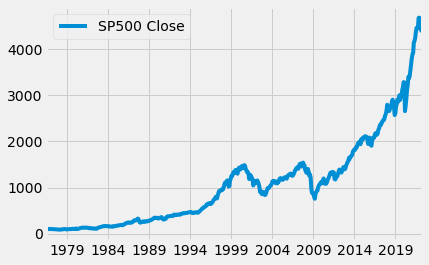

In [4]:
# Feature Selection - Only Close Data
df = data.filter(['SP500 Close'])
df.plot()
data_unscaled = df.values
# print(len(data_unscaled))
# data_unscaled

# train_data_length = math.ceil(len(data_unscaled) * 0.8)
# print(train_data_length)

# Standardization using MinMaxScaler (Scaling data to a range between 0 and 1)
mmscaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = mmscaler.fit_transform(data_unscaled)

In [5]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = df.columns.get_loc('SP500 Close')
print(index_Close)

0


In [6]:
# Split the data into training and testing data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_scaled.shape[0] * 0.8)

# Create the training, validation, and testing data
train_data = data_scaled[0:train_data_len, :]
test_data = data_scaled[train_data_len - sequence_length:, :]
print(train_data.shape)
print(test_data.shape)

(441, 1)
(160, 1)


In [7]:
train_index = df.index[0:train_data_len]
test_index = df.index[train_data_len - sequence_length:]
print(len(train_index))
print(len(test_index))

441
160


If we have an N-dimensional space and evolve over t-time steps, our input representation must be of shape `(num_samples, t, N)`. In other words, the RNN needs data with the format of [samples, time steps, features]. Here, we are building an univariate model on the S&P 500. Using the monthly aggregation, we have 551 observations and only 1 feature with the sequence length initailized to be 50.  

In [8]:
def partition_dataset(sequence_length, df):
    x, y = [], []
    data_len = df.shape[0]
    for i in range(sequence_length, data_len):
        # x has (data_len - sequence_length) number of sequence_length data window 
        x.append(df[i-sequence_length:i,:])  
        # y has the prediction values for validation,  for single-step prediction
        y.append(df[i, index_Close]) 
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [9]:
# Generate training data, validation, and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

(391, 50, 1) (391,)
(110, 50, 1) (110,)
0.31880164669451866
0.31880164669451866


In [10]:
model = tf.keras.models.load_model('saved_model/uni_model')

### Prediction
We use the fitted model to make predictions. Then, we need to scale it back to the orginal values because we used `MinMaxScaler` earlier. 

In [11]:
y_pred_scaled = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred_scaled)
# print(y_pred)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))
# print(y_test_unscaled)

In [12]:
print(len(x_test))
print(len(y_pred))
print(len(y_test))

110
110
110


### Model Evaluation

In [13]:
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = math.sqrt(mse)
print(f'Root Mean Square Error (RMSE): {np.round(rmse, 2)}')

Root Mean Square Error (RMSE): 870.98


In [14]:
def prediction_pi(y_pred):
    # y_pred = asarray(y_pred)
    # calculate 95% gaussian prediction interval
    interval = 1.96 * y_pred.std()
    lower, upper = y_pred - interval, y_pred + interval
    return lower, y_pred, upper

In [15]:
l, m, u = prediction_pi(y_pred)
# l, m, u

In [16]:
train_data_unscaled = mmscaler.inverse_transform(train_data.reshape(-1, 1))
# print(train_data_unscaled.shape)
# train_data_unscaled

In [17]:
train_data_unscaled = pd.DataFrame(train_data_unscaled, index=train_index, columns=['training data'])
y_test_unscaled = pd.DataFrame(y_test_unscaled, index=test_index[sequence_length:], columns=['actual test data'])
y_pred = pd.DataFrame(y_pred, index=test_index[sequence_length:], columns=['forecasting data'])

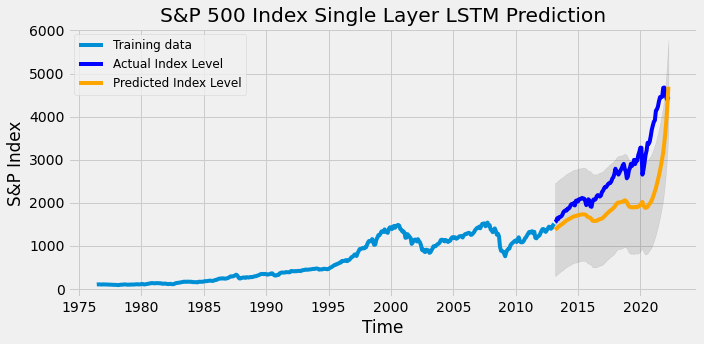

In [18]:
# Make as pandas series
fc_series = pd.Series(np.array(m.ravel()), index=test_index[sequence_length:])
lower_series = pd.Series(np.array(l.ravel()), index=test_index[sequence_length:])
upper_series = pd.Series(np.array(u.ravel()), index=test_index[sequence_length:])

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_data_unscaled, label='Training data') # training data 
plt.plot(y_test_unscaled, color = 'blue', label='Actual Index Level') # actual test data 
plt.plot(y_pred, color = 'orange',label='Predicted Index Level') # forecasted data 

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('S&P 500 Index Single Layer LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('S&P Index')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig('../Graph/S&P500 uniLSTM Prediction(M).png')
plt.show()

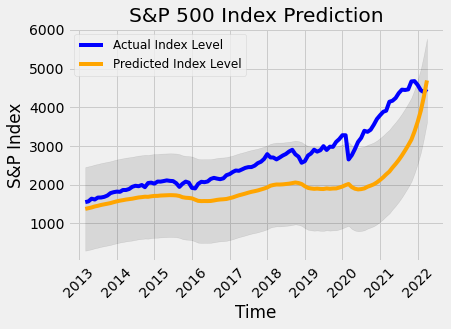

In [19]:
fc_series = pd.Series(np.array(m.ravel()), index=test_index[sequence_length:])
lower_series = pd.Series(np.array(l.ravel()), index=test_index[sequence_length:])
upper_series = pd.Series(np.array(u.ravel()), index=test_index[sequence_length:])
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)

plt.plot(y_test_unscaled, color = 'blue', label='Actual Index Level') # actual test data 
plt.plot(y_pred, color = 'orange',label='Predicted Index Level') # forecasted data 

plt.title('S&P 500 Index Prediction')
plt.xlabel('Time')
plt.ylabel('S&P Index')
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation = 45)
plt.show()